In [1]:
#!pip install fasttext
#!pip install transformers
#import nltk
#nltk.download('punkt')
#!pip3 install torch torchvision torchaudio

In [1]:
DATA_DIR = "./data/"
VALID_SIZE = .2
MODEL_PATH = "model_task2.bin"

In [2]:
import pandas as pd
import numpy as np
import scipy
import nltk
import re
import os
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from torch.optim import AdamW
from fasttext import load_model
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
from tqdm import tqdm
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import preprocessing, model_selection
from torch import LongTensor
from sklearn.metrics import f1_score, confusion_matrix, classification_report

---

In [3]:
df = pd.read_csv('../Dataset/data/restaurants_laptop_train_with_pos_task2_cleaned.csv')

In [4]:
df.polarity = df.polarity.replace(-1,2)

encoder = preprocessing.LabelEncoder()
df.loc[:, "aspect_tag"] = encoder.fit_transform(df["aspect_tag"])

sentences = df.groupby("num")["text"].apply(list).values
aspect_tags = df.groupby("num")["aspect_tag"].apply(list).values
polarity_tags = df.groupby("num")["polarity"].apply(list).values

polarity_unique_values = df.polarity.unique()

print('num of aspect tags: {}'.format(len(encoder.classes_)))
print('num of polarity tags: {}'.format(len(polarity_unique_values)))

np.where(encoder.classes_ == "AT")[0].item()

num of aspect tags: 2
num of polarity tags: 4


0

In [5]:
idx = 0
print(sentences[idx])
print(aspect_tags[idx])
print(polarity_tags[idx])

['I', 'charge', 'it', 'at', 'night', 'and', 'skip', 'taking', 'the', 'cord', 'with', 'me', 'because', 'of', 'the', 'good', 'battery', 'life']
[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1]


---

In [6]:
def get_new_aspect_cluster(left, right, aspect_term, polarity, sentence):

    if len(polarity) == 0:
        polarity = 0
    else:
        polarity = int(sum(polarity)/len(polarity))
   
    left.extend(aspect_term)
    left.extend(right)
    return {
        "local_context":left,
        "global_context":sentence,
        "aspect_term":aspect_term,
        "polarity":polarity,
    }

def chop(sentence, aspect_tag, polarity_tag):
    ret_aspect_clusters = []
#     ret_aspect_clusters = {
#         "context":list(),
#         "aspect_term":list(),
#         "polarity":list(),
#     }
    left = []
    right = []
    aspect_term = []
    polarity = []
    doing_left = True
    doing_right = False
    doing_aspect = False
    for i in range(len(sentence)):
        # check if the current token is an aspect term
        if aspect_tag[i] == 0:
            if doing_left:
                doing_aspect = True
                doing_left = False
            elif doing_right:
                doing_right = False
                doing_aspect = True
                # Now, need to save the previous aspect term cluster
                ret_aspect_clusters.append(get_new_aspect_cluster(
                    left, right, aspect_term, polarity, sentence))
                left = right
                right = []
                aspect_term = []
                polarity = []
            aspect_term.append(sentence[i])
            polarity.append(polarity_tag[i])
        else:
            if doing_left:
                left.append(sentence[i])
            elif doing_right:
                right.append(sentence[i])
            else:
                doing_aspect = False
                doing_right = True
                right.append(sentence[i])
                
    ret_aspect_clusters.append(get_new_aspect_cluster(
        left, right, aspect_term, polarity, sentence))
    
    return ret_aspect_clusters

In [7]:
all_aspect_clusters = []
for i in range(len(sentences)):
    all_aspect_clusters.extend(chop(sentences[i], aspect_tags[i], polarity_tags[i]))

In [9]:
# generate word_index list
def build_vocab(df):
    word_idx = {}
    for idx, word in enumerate(sorted(set(df.text.values))):
        word_idx[word] = idx + 1
    return word_idx

def gen_np_embedding(fn, word_idx, dim=100, emb=False):
    if emb:
        model = load_model(fn + ".bin")
    embedding = np.zeros((len(word_idx) + 2, dim))

    with open(fn, encoding="utf8") as f:
        for l in f:
            # for each line, get the word and its vector
            rec = l.rstrip().split(' ')
            if len(rec) == 2:  # skip the first line.
                continue
                # if the word in word_idx, fill the embedding
            if rec[0] in word_idx:
                embedding[word_idx[rec[0]]] = np.array([float(r) for r in rec[1:]])
    for w in word_idx:
        if embedding[word_idx[w]].sum() == 0.:
            if emb:
                embedding[word_idx[w]] = model.get_word_vector(w)
    return embedding

def create_train_data_restaurant(all_aspect_clusters,  word_idx, sent_len=83):

    train_X_local = np.zeros((len(all_aspect_clusters), sent_len), np.int16)
    train_X_global = np.zeros((len(all_aspect_clusters), sent_len), np.int16)

    train_y = np.zeros(len(all_aspect_clusters), np.int16)

    # iterate the asoect
    for sx, sent in enumerate(all_aspect_clusters):
        train_y[sx] = sent['polarity']
        global_sentence = sent['global_context']
        local_sentence = sent['local_context']
        # write word index and tag in train_X
        try:
            for wx, word in enumerate(global_sentence):
                train_X_global[sx, wx] = word_idx[word]

            for wx, word in enumerate(local_sentence):
                train_X_local[sx, wx] = word_idx[word]

        except KeyError:
            continue

    return train_X_local, train_X_global, train_y


def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')


def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    elif isinstance(data, dict):
        for k, v in data.items():
            data[k] = v.to(device)
        return data
    return data.to(device, non_blocking=True)


class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""

    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)


def loss_fn(pred, label, num_label):
    pred = pred.view(-1,num_label)
    label = label.view(-1)
    loss = torch.nn.functional.cross_entropy(pred, label)
    return loss


def cal_acc(pred_tags, true_tags):
    if isinstance(pred_tags, list):
        pred_tags = torch.cat(pred_tags, 0)
        true_tags = torch.cat(true_tags, 0)
    acc = (pred_tags == true_tags).sum() / pred_tags.numel()
    f1 = f1_score(true_tags.cpu().numpy(), pred_tags.cpu().numpy(), labels=[0, 1, 2], average='weighted')
    cm = confusion_matrix(true_tags.cpu().numpy(), pred_tags.cpu().numpy())
    return acc, f1, cm


class Model(torch.nn.Module):
    def __init__(self, gen_emb, num_classes=3, alpha = 0.6):
        super(Model, self).__init__()
  
        self.embed = nn.Embedding.from_pretrained(torch.tensor(gen_emb, dtype=torch.float))
        self.lstm_l = nn.LSTM(gen_emb.shape[1], hidden_size=150, num_layers=1, bidirectional=False, batch_first=True)
        self.lstm_r = nn.LSTM(gen_emb.shape[1],hidden_size=150, num_layers=1, bidirectional=False, batch_first=True)

        self.dense = nn.Linear(150*2, num_classes)

        self.lstm = nn.LSTM(gen_emb.shape[1], hidden_size=150, num_layers=1, bidirectional=True, batch_first=True)
        self.dense_1 = torch.nn.Linear(gen_emb.shape[1], num_classes)

        self.alpha = alpha
        self.dropout = nn.Dropout(0.3)


    def forward(self, x_train_local, x_train_global):
        x_local = self.embed(x_train_local)
        _, (h_n, _) = self.lstm(x_local.float())

        h_n = torch.cat([h_n[-2,:,:], h_n[-1,:,:]], dim=1)

        x_global = self.embed(x_train_global)
        _, (h_n_g,_) = self.lstm(x_global.float())

        h_n_g = torch.cat([h_n_g[-2,:,:], h_n_g[-1,:,:]], dim=1)

        avg_pool = torch.div(torch.add(h_n * (1 - self.alpha), h_n_g * self.alpha), 2)
        out = self.dropout(avg_pool)

        out = self.dense(out)


        return out

In [10]:
word_indx = build_vocab(df)
    
fn = DATA_DIR + 'glove.840B.300d.txt'
general_embedding = gen_np_embedding(fn, word_indx, dim=300, emb=False)

In [11]:
local_context, global_context, y = create_train_data_restaurant(all_aspect_clusters ,word_indx, sent_len=85)

X_l_train, X_l_valid, X_g_train, X_g_valid,  y_train, y_valid = train_test_split(local_context, global_context, y, test_size=VALID_SIZE)


## Alpha = 0

In [12]:
device = get_default_device()

NUM_EPOCHS = 20
TRAIN_BATCH_SIZE = 128
VALID_BATCH_SIZE = 1024

NUM_POLARITY_TAGS = 3

history = {
    "train_loss": list(),
    "polarity_train_acc": list(),
    "valid_loss": list(),
    "polarity_valid_acc": list(),
}

best_loss = np.inf

dataset = TensorDataset(torch.Tensor(X_l_train), torch.Tensor(X_g_train), torch.Tensor(y_train))
print(f"train samples:{len(dataset)}")
train_loader = DataLoader(dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True, drop_last=True)

dataset_valid = TensorDataset(torch.Tensor(X_l_valid),  torch.Tensor(X_g_valid), torch.Tensor(y_valid))
print(f"valid samples:{len(dataset_valid)}")
test_loader = DataLoader(dataset_valid, batch_size=VALID_BATCH_SIZE)

model = to_device(Model(general_embedding,  num_classes=3, alpha = 0), device)

torch.cuda.empty_cache()

parameters = [p for p in model.parameters() if p.requires_grad]
optimizer = AdamW(parameters, lr=1e-4)


for epoch in range(NUM_EPOCHS):
    train_losses = []
    train_acc = []
    test_loss = []
    test_acc = []
    train_f1 = []
    test_f1 = []

    model.train()
    preds = []
    masks = []
    labels = []
    for data in tqdm(train_loader, total=len(train_loader)):
        for i in range(len(data)):
            data[i] = data[i].to(device)
        l_feature, g_feature, label = data
        l_feature, g_feature, label = l_feature.long(), g_feature.long(), label.long()

        optimizer.zero_grad()
        pred_logits = model(l_feature, g_feature)
        loss = loss_fn(pred_logits, label, 3)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

        pred_tags = pred_logits.max(-1)[1]
        preds.append(pred_tags)
        labels.append(label)

    avg_train_acc, avg_train_f1, train_cm = cal_acc(preds,labels)
    avg_train_loss = sum(train_losses) / len(train_losses)

    preds = []
    masks = []
    labels = []
    with torch.no_grad():
        for data in tqdm(test_loader, total=len(test_loader)):
            for i in range(len(data)):
                data[i] = data[i].to(device)
            l_feature, g_feature, label = data
            l_feature, g_feature, label = l_feature.long(), g_feature.long(), label.long()
            pred_logits = model(l_feature, g_feature)
            loss = loss_fn(pred_logits, label, 3)

            test_loss.append(loss.item())

            pred_tags = pred_logits.max(-1)[1]

            preds.append(pred_tags)
            labels.append(label)

    avg_test_acc, avg_test_f1, test_cm = cal_acc(preds,  labels)
    avg_test_loss = sum(test_loss) / len(test_loss)

    print(f"\nepoch {epoch}")
    print("\ttrain_loss:{:.3f} valid_loss:{:.3f}".format(avg_train_loss, avg_test_loss))
    print("\ttrain_acc:{:.2%} valid_acc:{:.2%}".format(avg_train_acc, avg_test_acc))
    print("\ttrain_f1:{:.3f} valid_f1:{:.3f}".format(avg_train_f1, avg_test_f1))
    print(f"\ttrain_confusion_matrix:\n{train_cm}")
    print(f"\tvalid_confusion_matrix:\n{test_cm}")

    if avg_test_loss < best_loss:
        torch.save(model.state_dict(), MODEL_PATH)
        best_loss = avg_test_loss    
        
    history['train_loss'].append(avg_train_loss)
    history['polarity_train_acc'].append(avg_train_acc.cpu().numpy())
    history['valid_loss'].append(avg_test_loss)
    history['polarity_valid_acc'].append(avg_test_acc.cpu().numpy())
        
    


train samples:4641
valid samples:1161


100%|██████████| 2/2 [00:01<00:00,  1.46it/s]



epoch 0
	train_loss:1.072 valid_loss:1.043
	train_acc:51.61% valid_acc:53.57%
	train_f1:0.373 valid_f1:0.374
	train_confusion_matrix:
[[  21  866   13]
 [  43 2337   30]
 [  28 1250   20]]
	valid_confusion_matrix:
[[  0 212   0]
 [  0 622   0]
 [  0 327   0]]


100%|██████████| 2/2 [00:01<00:00,  1.48it/s]



epoch 1
	train_loss:1.026 valid_loss:0.992
	train_acc:52.15% valid_acc:53.57%
	train_f1:0.357 valid_f1:0.374
	train_confusion_matrix:
[[   0  901    0]
 [   0 2403    0]
 [   0 1304    0]]
	valid_confusion_matrix:
[[  0 212   0]
 [  0 622   0]
 [  0 327   0]]


100%|██████████| 2/2 [00:01<00:00,  1.55it/s]



epoch 2
	train_loss:0.991 valid_loss:0.960
	train_acc:52.13% valid_acc:53.57%
	train_f1:0.357 valid_f1:0.374
	train_confusion_matrix:
[[   0  905    0]
 [   0 2402    0]
 [   0 1301    0]]
	valid_confusion_matrix:
[[  0 212   0]
 [  0 622   0]
 [  0 327   0]]


100%|██████████| 2/2 [00:01<00:00,  1.50it/s]



epoch 3
	train_loss:0.941 valid_loss:0.892
	train_acc:52.78% valid_acc:56.93%
	train_f1:0.372 valid_f1:0.464
	train_confusion_matrix:
[[   0  880   17]
 [   0 2405    2]
 [   0 1277   27]]
	valid_confusion_matrix:
[[  0 190  22]
 [  0 598  24]
 [  0 264  63]]


100%|██████████| 2/2 [00:01<00:00,  1.53it/s]



epoch 4
	train_loss:0.883 valid_loss:0.854
	train_acc:59.92% valid_acc:60.64%
	train_f1:0.522 valid_f1:0.537
	train_confusion_matrix:
[[   0  597  302]
 [   0 2178  228]
 [   0  720  583]]
	valid_confusion_matrix:
[[  0 131  81]
 [  0 546  76]
 [  0 169 158]]


100%|██████████| 2/2 [00:01<00:00,  1.54it/s]



epoch 5
	train_loss:0.857 valid_loss:0.840
	train_acc:61.72% valid_acc:62.19%
	train_f1:0.546 valid_f1:0.557
	train_confusion_matrix:
[[   0  520  382]
 [   0 2115  289]
 [   0  573  729]]
	valid_confusion_matrix:
[[  0 114  98]
 [  0 537  85]
 [  0 142 185]]


100%|██████████| 2/2 [00:01<00:00,  1.61it/s]



epoch 6
	train_loss:0.829 valid_loss:0.820
	train_acc:63.30% valid_acc:63.31%
	train_f1:0.566 valid_f1:0.572
	train_confusion_matrix:
[[   0  438  462]
 [   0 2034  371]
 [   0  420  883]]
	valid_confusion_matrix:
[[  0 102 110]
 [  0 515 107]
 [  0 107 220]]


100%|██████████| 2/2 [00:01<00:00,  1.66it/s]



epoch 7
	train_loss:0.809 valid_loss:0.817
	train_acc:63.95% valid_acc:64.00%
	train_f1:0.571 valid_f1:0.574
	train_confusion_matrix:
[[   0  455  443]
 [   0 2070  338]
 [   0  425  877]]
	valid_confusion_matrix:
[[  0 116  96]
 [  0 544  78]
 [  0 128 199]]


100%|██████████| 2/2 [00:01<00:00,  1.60it/s]



epoch 8
	train_loss:0.787 valid_loss:0.803
	train_acc:65.65% valid_acc:64.51%
	train_f1:0.588 valid_f1:0.583
	train_confusion_matrix:
[[   0  427  470]
 [   0 2084  325]
 [   0  361  941]]
	valid_confusion_matrix:
[[  0 103 109]
 [  0 521 101]
 [  0  99 228]]


100%|██████████| 2/2 [00:01<00:00,  1.61it/s]



epoch 9
	train_loss:0.773 valid_loss:0.797
	train_acc:65.95% valid_acc:65.12%
	train_f1:0.591 valid_f1:0.590
	train_confusion_matrix:
[[   2  429  470]
 [   2 2078  328]
 [   0  340  959]]
	valid_confusion_matrix:
[[  1 103 108]
 [  1 524  97]
 [  0  96 231]]


100%|██████████| 2/2 [00:01<00:00,  1.67it/s]



epoch 10
	train_loss:0.761 valid_loss:0.797
	train_acc:66.75% valid_acc:65.72%
	train_f1:0.599 valid_f1:0.596
	train_confusion_matrix:
[[   4  429  467]
 [   3 2085  317]
 [   3  313  987]]
	valid_confusion_matrix:
[[  3 108 101]
 [  1 540  81]
 [  4 103 220]]


100%|██████████| 2/2 [00:01<00:00,  1.66it/s]



epoch 11
	train_loss:0.750 valid_loss:0.791
	train_acc:66.80% valid_acc:65.72%
	train_f1:0.606 valid_f1:0.603
	train_confusion_matrix:
[[  23  440  437]
 [  16 2102  286]
 [  13  338  953]]
	valid_confusion_matrix:
[[  8 112  92]
 [ 10 536  76]
 [  4 104 219]]


100%|██████████| 2/2 [00:01<00:00,  1.67it/s]



epoch 12
	train_loss:0.736 valid_loss:0.791
	train_acc:67.77% valid_acc:66.93%
	train_f1:0.625 valid_f1:0.618
	train_confusion_matrix:
[[  57  429  412]
 [  34 2095  283]
 [  20  307  971]]
	valid_confusion_matrix:
[[ 15 119  78]
 [  8 555  59]
 [  7 113 207]]


100%|██████████| 2/2 [00:01<00:00,  1.62it/s]



epoch 13
	train_loss:0.726 valid_loss:0.776
	train_acc:68.84% valid_acc:66.58%
	train_f1:0.639 valid_f1:0.625
	train_confusion_matrix:
[[  77  418  406]
 [  45 2098  264]
 [  18  285  997]]
	valid_confusion_matrix:
[[ 21 103  88]
 [ 19 534  69]
 [  8 101 218]]


100%|██████████| 2/2 [00:01<00:00,  1.66it/s]



epoch 14
	train_loss:0.721 valid_loss:0.778
	train_acc:69.31% valid_acc:65.37%
	train_f1:0.654 valid_f1:0.617
	train_confusion_matrix:
[[ 119  398  384]
 [  65 2082  254]
 [  36  277  993]]
	valid_confusion_matrix:
[[ 20  91 101]
 [ 18 500 104]
 [  7  81 239]]


100%|██████████| 2/2 [00:01<00:00,  1.64it/s]



epoch 15
	train_loss:0.716 valid_loss:0.778
	train_acc:68.49% valid_acc:65.98%
	train_f1:0.645 valid_f1:0.632
	train_confusion_matrix:
[[ 111  409  380]
 [  65 2086  254]
 [  48  296  959]]
	valid_confusion_matrix:
[[ 29  82 101]
 [ 25 497 100]
 [ 14  73 240]]


100%|██████████| 2/2 [00:01<00:00,  1.68it/s]



epoch 16
	train_loss:0.705 valid_loss:0.762
	train_acc:69.97% valid_acc:67.36%
	train_f1:0.665 valid_f1:0.640
	train_confusion_matrix:
[[ 145  390  368]
 [  77 2089  233]
 [  59  257  990]]
	valid_confusion_matrix:
[[ 29 102  81]
 [ 24 527  71]
 [ 13  88 226]]


100%|██████████| 2/2 [00:01<00:00,  1.66it/s]



epoch 17
	train_loss:0.693 valid_loss:0.777
	train_acc:70.36% valid_acc:67.96%
	train_f1:0.673 valid_f1:0.650
	train_confusion_matrix:
[[ 162  375  360]
 [  84 2087  235]
 [  70  242  993]]
	valid_confusion_matrix:
[[ 37  99  76]
 [ 23 536  63]
 [ 17  94 216]]


100%|██████████| 2/2 [00:01<00:00,  1.63it/s]



epoch 18
	train_loss:0.688 valid_loss:0.778
	train_acc:71.22% valid_acc:68.30%
	train_f1:0.683 valid_f1:0.659
	train_confusion_matrix:
[[ 172  360  362]
 [  80 2104  223]
 [  67  234 1006]]
	valid_confusion_matrix:
[[ 43  86  83]
 [ 25 526  71]
 [ 20  83 224]]


100%|██████████| 2/2 [00:01<00:00,  1.65it/s]


epoch 19
	train_loss:0.683 valid_loss:0.772
	train_acc:71.18% valid_acc:67.18%
	train_f1:0.688 valid_f1:0.649
	train_confusion_matrix:
[[ 206  349  346]
 [ 112 2086  208]
 [  90  223  988]]
	valid_confusion_matrix:
[[ 40  88  84]
 [ 30 511  81]
 [ 22  76 229]]


(0.4, 0.9)

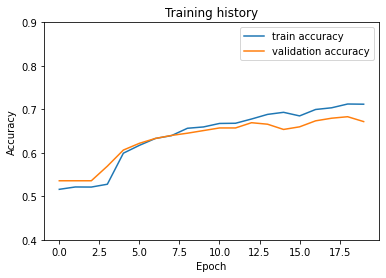

In [13]:
import matplotlib.pyplot as plt
plt.plot(history['polarity_train_acc'], label='train accuracy')
plt.plot(history['polarity_valid_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0.4, 0.9])

In [14]:
def get_classification_report(test_loader, model, model_path=None):
    if model_path is not None: # load the saved model
        print('Loading saved model from: {}'.format(model_path))
        model.load_state_dict(torch.load(model_path))
    model = to_device(model, device)   
    
    model.eval()
    final_pred_polarity_tags = []
    final_true_polarity_tags = []


    with torch.no_grad():
        for data in tqdm(test_loader, total=len(test_loader)):
            for i in range(len(data)):
                data[i] = data[i].to(device)

            l_feature, g_feature, label = data
            l_feature, g_feature, label = l_feature.long(), g_feature.long(), label.long()
            pred_logits = model(l_feature, g_feature)

            pred_tags = pred_logits.max(-1)[1]

            final_pred_polarity_tags.extend(pred_tags)
            final_true_polarity_tags.extend(label)

    final_pred_polarity_tags = torch.stack(final_pred_polarity_tags).cpu()
    final_true_polarity_tags = torch.stack(final_true_polarity_tags).cpu()
        
    print(classification_report(final_true_polarity_tags, final_pred_polarity_tags, 
                                target_names=["Neutral", "Positive", "Negative"]))
    
get_classification_report(test_loader, model, model_path=MODEL_PATH)

Loading saved model from: model_task2.bin


100%|██████████| 2/2 [00:01<00:00,  1.46it/s]

              precision    recall  f1-score   support

     Neutral       0.41      0.13      0.19       212
    Positive       0.73      0.85      0.79       622
    Negative       0.59      0.68      0.63       327

    accuracy                           0.67      1161
   macro avg       0.58      0.55      0.54      1161
weighted avg       0.63      0.67      0.63      1161



## Alpha = 0.2

In [15]:
device = get_default_device()

NUM_EPOCHS = 20
TRAIN_BATCH_SIZE = 128
VALID_BATCH_SIZE = 1024

NUM_POLARITY_TAGS = 3

history = {
    "train_loss": list(),
    "polarity_train_acc": list(),
    "valid_loss": list(),
    "polarity_valid_acc": list(),
}

best_loss = np.inf

dataset = TensorDataset(torch.Tensor(X_l_train), torch.Tensor(X_g_train), torch.Tensor(y_train))
print(f"train samples:{len(dataset)}")
train_loader = DataLoader(dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True, drop_last=True)

dataset_valid = TensorDataset(torch.Tensor(X_l_valid),  torch.Tensor(X_g_valid), torch.Tensor(y_valid))
print(f"valid samples:{len(dataset_valid)}")
test_loader = DataLoader(dataset_valid, batch_size=VALID_BATCH_SIZE)

model = to_device(Model(general_embedding,  num_classes=3, alpha = 0.2), device)

torch.cuda.empty_cache()

parameters = [p for p in model.parameters() if p.requires_grad]
optimizer = AdamW(parameters, lr=1e-4)


for epoch in range(NUM_EPOCHS):
    train_losses = []
    train_acc = []
    test_loss = []
    test_acc = []
    train_f1 = []
    test_f1 = []

    model.train()
    preds = []
    masks = []
    labels = []
    for data in tqdm(train_loader, total=len(train_loader)):
        for i in range(len(data)):
            data[i] = data[i].to(device)
        l_feature, g_feature, label = data
        l_feature, g_feature, label = l_feature.long(), g_feature.long(), label.long()

        optimizer.zero_grad()
        pred_logits = model(l_feature, g_feature)
        loss = loss_fn(pred_logits, label, 3)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

        pred_tags = pred_logits.max(-1)[1]
        preds.append(pred_tags)
        labels.append(label)

    avg_train_acc, avg_train_f1, train_cm = cal_acc(preds,labels)
    avg_train_loss = sum(train_losses) / len(train_losses)

    preds = []
    masks = []
    labels = []
    with torch.no_grad():
        for data in tqdm(test_loader, total=len(test_loader)):
            for i in range(len(data)):
                data[i] = data[i].to(device)
            l_feature, g_feature, label = data
            l_feature, g_feature, label = l_feature.long(), g_feature.long(), label.long()
            pred_logits = model(l_feature, g_feature)
            loss = loss_fn(pred_logits, label, 3)

            test_loss.append(loss.item())

            pred_tags = pred_logits.max(-1)[1]

            preds.append(pred_tags)
            labels.append(label)

    avg_test_acc, avg_test_f1, test_cm = cal_acc(preds,  labels)
    avg_test_loss = sum(test_loss) / len(test_loss)

    print(f"\nepoch {epoch}")
    print("\ttrain_loss:{:.3f} valid_loss:{:.3f}".format(avg_train_loss, avg_test_loss))
    print("\ttrain_acc:{:.2%} valid_acc:{:.2%}".format(avg_train_acc, avg_test_acc))
    print("\ttrain_f1:{:.3f} valid_f1:{:.3f}".format(avg_train_f1, avg_test_f1))
    print(f"\ttrain_confusion_matrix:\n{train_cm}")
    print(f"\tvalid_confusion_matrix:\n{test_cm}")

    if avg_test_loss < best_loss:
        torch.save(model.state_dict(), MODEL_PATH)
        best_loss = avg_test_loss    
        
    history['train_loss'].append(avg_train_loss)
    history['polarity_train_acc'].append(avg_train_acc.cpu().numpy())
    history['valid_loss'].append(avg_test_loss)
    history['polarity_valid_acc'].append(avg_test_acc.cpu().numpy())
        
    


train samples:4641
valid samples:1161


100%|██████████| 2/2 [00:01<00:00,  1.53it/s]



epoch 0
	train_loss:1.081 valid_loss:1.050
	train_acc:46.16% valid_acc:53.57%
	train_f1:0.371 valid_f1:0.374
	train_confusion_matrix:
[[ 181  718    0]
 [ 463 1946    0]
 [ 232 1068    0]]
	valid_confusion_matrix:
[[  0 212   0]
 [  0 622   0]
 [  1 326   0]]


100%|██████████| 2/2 [00:01<00:00,  1.55it/s]



epoch 1
	train_loss:1.034 valid_loss:0.996
	train_acc:52.08% valid_acc:53.57%
	train_f1:0.357 valid_f1:0.374
	train_confusion_matrix:
[[   0  904    0]
 [   0 2400    0]
 [   0 1304    0]]
	valid_confusion_matrix:
[[  0 212   0]
 [  0 622   0]
 [  0 327   0]]


100%|██████████| 2/2 [00:01<00:00,  1.55it/s]



epoch 2
	train_loss:0.991 valid_loss:0.957
	train_acc:52.17% valid_acc:53.57%
	train_f1:0.358 valid_f1:0.374
	train_confusion_matrix:
[[   0  902    0]
 [   0 2404    0]
 [   0 1302    0]]
	valid_confusion_matrix:
[[  0 212   0]
 [  0 622   0]
 [  0 327   0]]


100%|██████████| 2/2 [00:01<00:00,  1.55it/s]



epoch 3
	train_loss:0.934 valid_loss:0.878
	train_acc:53.12% valid_acc:57.11%
	train_f1:0.379 valid_f1:0.467
	train_confusion_matrix:
[[   0  881   17]
 [   0 2406    4]
 [   0 1258   42]]
	valid_confusion_matrix:
[[  0 188  24]
 [  0 598  24]
 [  0 262  65]]


100%|██████████| 2/2 [00:01<00:00,  1.54it/s]



epoch 4
	train_loss:0.872 valid_loss:0.831
	train_acc:60.00% valid_acc:62.10%
	train_f1:0.520 valid_f1:0.551
	train_confusion_matrix:
[[   0  613  291]
 [   0 2206  195]
 [   0  744  559]]
	valid_confusion_matrix:
[[  0 133  79]
 [  0 553  69]
 [  0 159 168]]


100%|██████████| 2/2 [00:01<00:00,  1.53it/s]



epoch 5
	train_loss:0.839 valid_loss:0.810
	train_acc:62.07% valid_acc:62.53%
	train_f1:0.553 valid_f1:0.562
	train_confusion_matrix:
[[   0  470  431]
 [   0 2061  346]
 [   0  501  799]]
	valid_confusion_matrix:
[[  0 113  99]
 [  0 526  96]
 [  0 127 200]]


100%|██████████| 2/2 [00:01<00:00,  1.53it/s]



epoch 6
	train_loss:0.813 valid_loss:0.799
	train_acc:63.37% valid_acc:62.79%
	train_f1:0.567 valid_f1:0.567
	train_confusion_matrix:
[[   0  431  463]
 [   0 2055  355]
 [   0  439  865]]
	valid_confusion_matrix:
[[  0  99 113]
 [  0 516 106]
 [  0 114 213]]


100%|██████████| 2/2 [00:01<00:00,  1.57it/s]



epoch 7
	train_loss:0.793 valid_loss:0.788
	train_acc:64.17% valid_acc:64.77%
	train_f1:0.574 valid_f1:0.583
	train_confusion_matrix:
[[   0  412  488]
 [   0 2051  350]
 [   0  401  906]]
	valid_confusion_matrix:
[[  0 105 107]
 [  0 540  82]
 [  0 115 212]]


100%|██████████| 2/2 [00:01<00:00,  1.53it/s]



epoch 8
	train_loss:0.777 valid_loss:0.781
	train_acc:65.49% valid_acc:64.86%
	train_f1:0.587 valid_f1:0.584
	train_confusion_matrix:
[[   0  403  497]
 [   0 2070  335]
 [   0  355  948]]
	valid_confusion_matrix:
[[  0 103 109]
 [  0 539  83]
 [  0 113 214]]


100%|██████████| 2/2 [00:01<00:00,  1.55it/s]



epoch 9
	train_loss:0.762 valid_loss:0.768
	train_acc:66.38% valid_acc:65.63%
	train_f1:0.594 valid_f1:0.592
	train_confusion_matrix:
[[   0  417  486]
 [   1 2087  316]
 [   0  329  972]]
	valid_confusion_matrix:
[[  0  99 113]
 [  0 534  88]
 [  0  99 228]]


100%|██████████| 2/2 [00:01<00:00,  1.55it/s]



epoch 10
	train_loss:0.749 valid_loss:0.769
	train_acc:67.14% valid_acc:65.98%
	train_f1:0.602 valid_f1:0.594
	train_confusion_matrix:
[[   3  414  484]
 [   0 2091  315]
 [   0  301 1000]]
	valid_confusion_matrix:
[[  0 108 104]
 [  1 543  78]
 [  0 104 223]]


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]



epoch 11
	train_loss:0.733 valid_loss:0.762
	train_acc:67.95% valid_acc:67.10%
	train_f1:0.609 valid_f1:0.609
	train_confusion_matrix:
[[   5  434  461]
 [   5 2136  266]
 [   1  310  990]]
	valid_confusion_matrix:
[[  2  99 111]
 [  2 535  85]
 [  1  84 242]]


100%|██████████| 2/2 [00:01<00:00,  1.56it/s]



epoch 12
	train_loss:0.726 valid_loss:0.758
	train_acc:67.99% valid_acc:66.58%
	train_f1:0.615 valid_f1:0.605
	train_confusion_matrix:
[[  16  429  454]
 [  14 2115  278]
 [   8  292 1002]]
	valid_confusion_matrix:
[[  2 103 107]
 [  5 537  80]
 [  3  90 234]]


100%|██████████| 2/2 [00:01<00:00,  1.54it/s]



epoch 13
	train_loss:0.712 valid_loss:0.751
	train_acc:68.92% valid_acc:67.18%
	train_f1:0.628 valid_f1:0.617
	train_confusion_matrix:
[[  30  417  448]
 [  15 2124  270]
 [  10  272 1022]]
	valid_confusion_matrix:
[[  9 107  96]
 [  6 546  70]
 [  3  99 225]]


100%|██████████| 2/2 [00:01<00:00,  1.53it/s]



epoch 14
	train_loss:0.709 valid_loss:0.762
	train_acc:69.62% valid_acc:67.44%
	train_f1:0.641 valid_f1:0.625
	train_confusion_matrix:
[[  55  405  440]
 [  25 2126  256]
 [  20  254 1027]]
	valid_confusion_matrix:
[[ 17 113  82]
 [  8 557  57]
 [  6 112 209]]


100%|██████████| 2/2 [00:01<00:00,  1.56it/s]



epoch 15
	train_loss:0.698 valid_loss:0.751
	train_acc:69.90% valid_acc:68.13%
	train_f1:0.648 valid_f1:0.633
	train_confusion_matrix:
[[  76  421  405]
 [  35 2143  229]
 [  27  270 1002]]
	valid_confusion_matrix:
[[ 15  98  99]
 [  7 538  77]
 [  4  85 238]]


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]



epoch 16
	train_loss:0.688 valid_loss:0.742
	train_acc:70.49% valid_acc:67.36%
	train_f1:0.658 valid_f1:0.636
	train_confusion_matrix:
[[  89  396  416]
 [  42 2138  223]
 [  34  249 1021]]
	valid_confusion_matrix:
[[ 21  89 102]
 [ 16 516  90]
 [ 10  72 245]]


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]



epoch 17
	train_loss:0.683 valid_loss:0.746
	train_acc:70.57% valid_acc:68.39%
	train_f1:0.663 valid_f1:0.649
	train_confusion_matrix:
[[ 106  383  411]
 [  51 2119  232]
 [  44  235 1027]]
	valid_confusion_matrix:
[[ 28  95  89]
 [ 15 526  81]
 [  8  79 240]]


100%|██████████| 2/2 [00:01<00:00,  1.53it/s]



epoch 18
	train_loss:0.674 valid_loss:0.737
	train_acc:71.31% valid_acc:69.25%
	train_f1:0.676 valid_f1:0.662
	train_confusion_matrix:
[[ 134  383  379]
 [  62 2151  195]
 [  58  245 1001]]
	valid_confusion_matrix:
[[ 34  89  89]
 [ 18 529  75]
 [ 13  73 241]]


100%|██████████| 2/2 [00:01<00:00,  1.54it/s]


epoch 19
	train_loss:0.668 valid_loss:0.729
	train_acc:71.44% valid_acc:69.60%
	train_f1:0.680 valid_f1:0.668
	train_confusion_matrix:
[[ 150  366  386]
 [  66 2128  210]
 [  67  221 1014]]
	valid_confusion_matrix:
[[ 37  83  92]
 [ 19 527  76]
 [ 14  69 244]]


(0.4, 0.9)

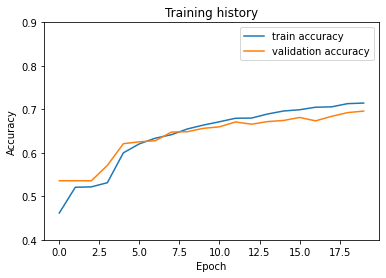

In [16]:
import matplotlib.pyplot as plt
plt.plot(history['polarity_train_acc'], label='train accuracy')
plt.plot(history['polarity_valid_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0.4, 0.9])

In [17]:
def get_classification_report(test_loader, model, model_path=None):
    if model_path is not None: # load the saved model
        print('Loading saved model from: {}'.format(model_path))
        model.load_state_dict(torch.load(model_path))
    model = to_device(model, device)   
    
    model.eval()
    final_pred_polarity_tags = []
    final_true_polarity_tags = []


    with torch.no_grad():
        for data in tqdm(test_loader, total=len(test_loader)):
            for i in range(len(data)):
                data[i] = data[i].to(device)

            l_feature, g_feature, label = data
            l_feature, g_feature, label = l_feature.long(), g_feature.long(), label.long()
            pred_logits = model(l_feature, g_feature)

            pred_tags = pred_logits.max(-1)[1]

            final_pred_polarity_tags.extend(pred_tags)
            final_true_polarity_tags.extend(label)

    final_pred_polarity_tags = torch.stack(final_pred_polarity_tags).cpu()
    final_true_polarity_tags = torch.stack(final_true_polarity_tags).cpu()
        
    print(classification_report(final_true_polarity_tags, final_pred_polarity_tags, 
                                target_names=["Neutral", "Positive", "Negative"]))
    
get_classification_report(test_loader, model, model_path=MODEL_PATH)

Loading saved model from: model_task2.bin


100%|██████████| 2/2 [00:01<00:00,  1.43it/s]

              precision    recall  f1-score   support

     Neutral       0.51      0.17      0.25       212
    Positive       0.78      0.84      0.81       622
    Negative       0.59      0.75      0.66       327

    accuracy                           0.69      1161
   macro avg       0.62      0.59      0.57      1161
weighted avg       0.67      0.69      0.66      1161



## Alpha = 0.4

In [18]:
device = get_default_device()

NUM_EPOCHS = 20
TRAIN_BATCH_SIZE = 128
VALID_BATCH_SIZE = 1024

NUM_POLARITY_TAGS = 3

history = {
    "train_loss": list(),
    "polarity_train_acc": list(),
    "valid_loss": list(),
    "polarity_valid_acc": list(),
}

best_loss = np.inf

dataset = TensorDataset(torch.Tensor(X_l_train), torch.Tensor(X_g_train), torch.Tensor(y_train))
print(f"train samples:{len(dataset)}")
train_loader = DataLoader(dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True, drop_last=True)

dataset_valid = TensorDataset(torch.Tensor(X_l_valid),  torch.Tensor(X_g_valid), torch.Tensor(y_valid))
print(f"valid samples:{len(dataset_valid)}")
test_loader = DataLoader(dataset_valid, batch_size=VALID_BATCH_SIZE)

model = to_device(Model(general_embedding,  num_classes=3, alpha = 0.4), device)

torch.cuda.empty_cache()

parameters = [p for p in model.parameters() if p.requires_grad]
optimizer = AdamW(parameters, lr=1e-4)


for epoch in range(NUM_EPOCHS):
    train_losses = []
    train_acc = []
    test_loss = []
    test_acc = []
    train_f1 = []
    test_f1 = []

    model.train()
    preds = []
    masks = []
    labels = []
    for data in tqdm(train_loader, total=len(train_loader)):
        for i in range(len(data)):
            data[i] = data[i].to(device)
        l_feature, g_feature, label = data
        l_feature, g_feature, label = l_feature.long(), g_feature.long(), label.long()

        optimizer.zero_grad()
        pred_logits = model(l_feature, g_feature)
        loss = loss_fn(pred_logits, label, 3)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

        pred_tags = pred_logits.max(-1)[1]
        preds.append(pred_tags)
        labels.append(label)

    avg_train_acc, avg_train_f1, train_cm = cal_acc(preds,labels)
    avg_train_loss = sum(train_losses) / len(train_losses)

    preds = []
    masks = []
    labels = []
    with torch.no_grad():
        for data in tqdm(test_loader, total=len(test_loader)):
            for i in range(len(data)):
                data[i] = data[i].to(device)
            l_feature, g_feature, label = data
            l_feature, g_feature, label = l_feature.long(), g_feature.long(), label.long()
            pred_logits = model(l_feature, g_feature)
            loss = loss_fn(pred_logits, label, 3)

            test_loss.append(loss.item())

            pred_tags = pred_logits.max(-1)[1]

            preds.append(pred_tags)
            labels.append(label)

    avg_test_acc, avg_test_f1, test_cm = cal_acc(preds,  labels)
    avg_test_loss = sum(test_loss) / len(test_loss)

    print(f"\nepoch {epoch}")
    print("\ttrain_loss:{:.3f} valid_loss:{:.3f}".format(avg_train_loss, avg_test_loss))
    print("\ttrain_acc:{:.2%} valid_acc:{:.2%}".format(avg_train_acc, avg_test_acc))
    print("\ttrain_f1:{:.3f} valid_f1:{:.3f}".format(avg_train_f1, avg_test_f1))
    print(f"\ttrain_confusion_matrix:\n{train_cm}")
    print(f"\tvalid_confusion_matrix:\n{test_cm}")

    if avg_test_loss < best_loss:
        torch.save(model.state_dict(), MODEL_PATH)
        best_loss = avg_test_loss    
        
    history['train_loss'].append(avg_train_loss)
    history['polarity_train_acc'].append(avg_train_acc.cpu().numpy())
    history['valid_loss'].append(avg_test_loss)
    history['polarity_valid_acc'].append(avg_test_acc.cpu().numpy())
        
    


train samples:4641
valid samples:1161


100%|██████████| 2/2 [00:01<00:00,  1.53it/s]



epoch 0
	train_loss:1.087 valid_loss:1.059
	train_acc:41.56% valid_acc:53.49%
	train_f1:0.359 valid_f1:0.374
	train_confusion_matrix:
[[ 338  562    0]
 [ 826 1576    1]
 [ 479  825    1]]
	valid_confusion_matrix:
[[  0 212   0]
 [  0 621   1]
 [  2 325   0]]


100%|██████████| 2/2 [00:01<00:00,  1.62it/s]



epoch 1
	train_loss:1.035 valid_loss:0.996
	train_acc:52.32% valid_acc:53.57%
	train_f1:0.360 valid_f1:0.374
	train_confusion_matrix:
[[   0  898    0]
 [   0 2410    0]
 [   1 1298    1]]
	valid_confusion_matrix:
[[  0 212   0]
 [  0 622   0]
 [  0 327   0]]


100%|██████████| 2/2 [00:01<00:00,  1.66it/s]



epoch 2
	train_loss:0.991 valid_loss:0.963
	train_acc:52.26% valid_acc:53.57%
	train_f1:0.359 valid_f1:0.374
	train_confusion_matrix:
[[   0  900    0]
 [   0 2408    0]
 [   0 1300    0]]
	valid_confusion_matrix:
[[  0 212   0]
 [  0 622   0]
 [  0 327   0]]


100%|██████████| 2/2 [00:01<00:00,  1.64it/s]



epoch 3
	train_loss:0.941 valid_loss:0.894
	train_acc:52.73% valid_acc:55.81%
	train_f1:0.372 valid_f1:0.434
	train_confusion_matrix:
[[   0  893   10]
 [   0 2401    3]
 [   0 1272   29]]
	valid_confusion_matrix:
[[  0 205   7]
 [  0 610  12]
 [  0 289  38]]


100%|██████████| 2/2 [00:01<00:00,  1.63it/s]



epoch 4
	train_loss:0.878 valid_loss:0.838
	train_acc:59.61% valid_acc:62.79%
	train_f1:0.517 valid_f1:0.561
	train_confusion_matrix:
[[   0  614  286]
 [   0 2192  216]
 [   0  745  555]]
	valid_confusion_matrix:
[[  0 129  83]
 [  0 540  82]
 [  0 138 189]]


100%|██████████| 2/2 [00:01<00:00,  1.69it/s]



epoch 5
	train_loss:0.837 valid_loss:0.813
	train_acc:62.98% valid_acc:63.57%
	train_f1:0.561 valid_f1:0.572
	train_confusion_matrix:
[[   0  470  430]
 [   0 2077  330]
 [   0  476  825]]
	valid_confusion_matrix:
[[  0 112 100]
 [  0 529  93]
 [  0 118 209]]


100%|██████████| 2/2 [00:01<00:00,  1.64it/s]



epoch 6
	train_loss:0.808 valid_loss:0.797
	train_acc:64.24% valid_acc:65.03%
	train_f1:0.574 valid_f1:0.586
	train_confusion_matrix:
[[   0  428  471]
 [   0 2061  341]
 [   0  408  899]]
	valid_confusion_matrix:
[[  0 103 109]
 [  0 539  83]
 [  0 111 216]]


100%|██████████| 2/2 [00:01<00:00,  1.64it/s]



epoch 7
	train_loss:0.784 valid_loss:0.784
	train_acc:65.97% valid_acc:65.63%
	train_f1:0.592 valid_f1:0.592
	train_confusion_matrix:
[[   0  394  509]
 [   0 2051  351]
 [   0  314  989]]
	valid_confusion_matrix:
[[  0 101 111]
 [  0 538  84]
 [  0 103 224]]


100%|██████████| 2/2 [00:01<00:00,  1.64it/s]



epoch 8
	train_loss:0.763 valid_loss:0.782
	train_acc:66.78% valid_acc:66.06%
	train_f1:0.599 valid_f1:0.595
	train_confusion_matrix:
[[   0  405  491]
 [   0 2063  345]
 [   0  290 1014]]
	valid_confusion_matrix:
[[  0 106 106]
 [  1 542  79]
 [  0 102 225]]


100%|██████████| 2/2 [00:01<00:00,  1.65it/s]



epoch 9
	train_loss:0.751 valid_loss:0.772
	train_acc:66.78% valid_acc:66.84%
	train_f1:0.600 valid_f1:0.604
	train_confusion_matrix:
[[   4  402  495]
 [   2 2063  339]
 [   1  292 1010]]
	valid_confusion_matrix:
[[  3 115  94]
 [  1 557  64]
 [  1 110 216]]


100%|██████████| 2/2 [00:01<00:00,  1.66it/s]



epoch 10
	train_loss:0.733 valid_loss:0.762
	train_acc:68.14% valid_acc:67.10%
	train_f1:0.616 valid_f1:0.611
	train_confusion_matrix:
[[  17  425  457]
 [   5 2090  308]
 [   5  268 1033]]
	valid_confusion_matrix:
[[  4 109  99]
 [  5 542  75]
 [  2  92 233]]


100%|██████████| 2/2 [00:01<00:00,  1.67it/s]



epoch 11
	train_loss:0.721 valid_loss:0.760
	train_acc:68.75% valid_acc:68.04%
	train_f1:0.623 valid_f1:0.622
	train_confusion_matrix:
[[  23  445  427]
 [  12 2119  277]
 [   7  272 1026]]
	valid_confusion_matrix:
[[  8 113  91]
 [  3 554  65]
 [  4  95 228]]


100%|██████████| 2/2 [00:01<00:00,  1.64it/s]



epoch 12
	train_loss:0.710 valid_loss:0.754
	train_acc:69.34% valid_acc:67.44%
	train_f1:0.634 valid_f1:0.628
	train_confusion_matrix:
[[  39  434  431]
 [  26 2108  273]
 [  12  237 1048]]
	valid_confusion_matrix:
[[ 14  95 103]
 [  8 526  88]
 [  5  79 243]]


100%|██████████| 2/2 [00:01<00:00,  1.65it/s]



epoch 13
	train_loss:0.700 valid_loss:0.749
	train_acc:69.94% valid_acc:68.82%
	train_f1:0.645 valid_f1:0.636
	train_confusion_matrix:
[[  60  420  417]
 [  30 2115  262]
 [  18  238 1048]]
	valid_confusion_matrix:
[[ 14 116  82]
 [  6 557  59]
 [  4  95 228]]


100%|██████████| 2/2 [00:01<00:00,  1.67it/s]



epoch 14
	train_loss:0.692 valid_loss:0.743
	train_acc:70.38% valid_acc:68.91%
	train_f1:0.657 valid_f1:0.645
	train_confusion_matrix:
[[  87  410  402]
 [  45 2118  245]
 [  32  231 1038]]
	valid_confusion_matrix:
[[ 23 115  74]
 [ 13 563  46]
 [ 12 101 214]]


100%|██████████| 2/2 [00:01<00:00,  1.69it/s]



epoch 15
	train_loss:0.685 valid_loss:0.749
	train_acc:70.46% valid_acc:69.25%
	train_f1:0.663 valid_f1:0.650
	train_confusion_matrix:
[[ 108  411  384]
 [  58 2115  230]
 [  56  222 1024]]
	valid_confusion_matrix:
[[ 23 115  74]
 [ 15 560  47]
 [ 12  94 221]]


100%|██████████| 2/2 [00:01<00:00,  1.63it/s]



epoch 16
	train_loss:0.675 valid_loss:0.732
	train_acc:71.59% valid_acc:69.25%
	train_f1:0.678 valid_f1:0.655
	train_confusion_matrix:
[[ 132  386  382]
 [  57 2127  222]
 [  59  203 1040]]
	valid_confusion_matrix:
[[ 26  92  94]
 [ 17 534  71]
 [  6  77 244]]


100%|██████████| 2/2 [00:01<00:00,  1.64it/s]



epoch 17
	train_loss:0.669 valid_loss:0.745
	train_acc:71.83% valid_acc:69.16%
	train_f1:0.682 valid_f1:0.658
	train_confusion_matrix:
[[ 145  395  361]
 [  62 2133  208]
 [  65  207 1032]]
	valid_confusion_matrix:
[[ 29  81 102]
 [ 14 523  85]
 [  9  67 251]]


100%|██████████| 2/2 [00:01<00:00,  1.66it/s]



epoch 18
	train_loss:0.661 valid_loss:0.719
	train_acc:72.35% valid_acc:69.60%
	train_f1:0.690 valid_f1:0.671
	train_confusion_matrix:
[[ 151  358  388]
 [  72 2119  217]
 [  58  181 1064]]
	valid_confusion_matrix:
[[ 47  97  68]
 [ 25 547  50]
 [ 21  92 214]]


100%|██████████| 2/2 [00:01<00:00,  1.61it/s]


epoch 19
	train_loss:0.657 valid_loss:0.721
	train_acc:72.46% valid_acc:69.60%
	train_f1:0.695 valid_f1:0.669
	train_confusion_matrix:
[[ 181  363  356]
 [  85 2127  192]
 [  79  194 1031]]
	valid_confusion_matrix:
[[ 42  92  78]
 [ 19 543  60]
 [ 21  83 223]]


(0.4, 0.9)

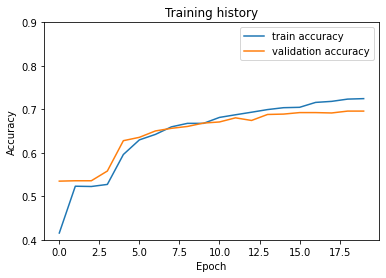

In [19]:
import matplotlib.pyplot as plt
plt.plot(history['polarity_train_acc'], label='train accuracy')
plt.plot(history['polarity_valid_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0.4, 0.9])

In [20]:
def get_classification_report(test_loader, model, model_path=None):
    if model_path is not None: # load the saved model
        print('Loading saved model from: {}'.format(model_path))
        model.load_state_dict(torch.load(model_path))
    model = to_device(model, device)   
    
    model.eval()
    final_pred_polarity_tags = []
    final_true_polarity_tags = []


    with torch.no_grad():
        for data in tqdm(test_loader, total=len(test_loader)):
            for i in range(len(data)):
                data[i] = data[i].to(device)

            l_feature, g_feature, label = data
            l_feature, g_feature, label = l_feature.long(), g_feature.long(), label.long()
            pred_logits = model(l_feature, g_feature)

            pred_tags = pred_logits.max(-1)[1]

            final_pred_polarity_tags.extend(pred_tags)
            final_true_polarity_tags.extend(label)

    final_pred_polarity_tags = torch.stack(final_pred_polarity_tags).cpu()
    final_true_polarity_tags = torch.stack(final_true_polarity_tags).cpu()
        
    print(classification_report(final_true_polarity_tags, final_pred_polarity_tags, 
                                target_names=["Neutral", "Positive", "Negative"]))
    
get_classification_report(test_loader, model, model_path=MODEL_PATH)

Loading saved model from: model_task2.bin


100%|██████████| 2/2 [00:01<00:00,  1.54it/s]

              precision    recall  f1-score   support

     Neutral       0.51      0.20      0.29       212
    Positive       0.74      0.89      0.81       622
    Negative       0.64      0.65      0.65       327

    accuracy                           0.70      1161
   macro avg       0.63      0.58      0.58      1161
weighted avg       0.67      0.70      0.67      1161



## Alpha = 0.6

In [21]:
device = get_default_device()

NUM_EPOCHS = 20
TRAIN_BATCH_SIZE = 128
VALID_BATCH_SIZE = 1024

NUM_POLARITY_TAGS = 3

history = {
    "train_loss": list(),
    "polarity_train_acc": list(),
    "valid_loss": list(),
    "polarity_valid_acc": list(),
}

best_loss = np.inf

dataset = TensorDataset(torch.Tensor(X_l_train), torch.Tensor(X_g_train), torch.Tensor(y_train))
print(f"train samples:{len(dataset)}")
train_loader = DataLoader(dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True, drop_last=True)

dataset_valid = TensorDataset(torch.Tensor(X_l_valid),  torch.Tensor(X_g_valid), torch.Tensor(y_valid))
print(f"valid samples:{len(dataset_valid)}")
test_loader = DataLoader(dataset_valid, batch_size=VALID_BATCH_SIZE)

model = to_device(Model(general_embedding,  num_classes=3, alpha = 0.6), device)

torch.cuda.empty_cache()

parameters = [p for p in model.parameters() if p.requires_grad]
optimizer = AdamW(parameters, lr=1e-4)


for epoch in range(NUM_EPOCHS):
    train_losses = []
    train_acc = []
    test_loss = []
    test_acc = []
    train_f1 = []
    test_f1 = []

    model.train()
    preds = []
    masks = []
    labels = []
    for data in tqdm(train_loader, total=len(train_loader)):
        for i in range(len(data)):
            data[i] = data[i].to(device)
        l_feature, g_feature, label = data
        l_feature, g_feature, label = l_feature.long(), g_feature.long(), label.long()

        optimizer.zero_grad()
        pred_logits = model(l_feature, g_feature)
        loss = loss_fn(pred_logits, label, 3)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

        pred_tags = pred_logits.max(-1)[1]
        preds.append(pred_tags)
        labels.append(label)

    avg_train_acc, avg_train_f1, train_cm = cal_acc(preds,labels)
    avg_train_loss = sum(train_losses) / len(train_losses)

    preds = []
    masks = []
    labels = []
    with torch.no_grad():
        for data in tqdm(test_loader, total=len(test_loader)):
            for i in range(len(data)):
                data[i] = data[i].to(device)
            l_feature, g_feature, label = data
            l_feature, g_feature, label = l_feature.long(), g_feature.long(), label.long()
            pred_logits = model(l_feature, g_feature)
            loss = loss_fn(pred_logits, label, 3)

            test_loss.append(loss.item())

            pred_tags = pred_logits.max(-1)[1]

            preds.append(pred_tags)
            labels.append(label)

    avg_test_acc, avg_test_f1, test_cm = cal_acc(preds,  labels)
    avg_test_loss = sum(test_loss) / len(test_loss)

    print(f"\nepoch {epoch}")
    print("\ttrain_loss:{:.3f} valid_loss:{:.3f}".format(avg_train_loss, avg_test_loss))
    print("\ttrain_acc:{:.2%} valid_acc:{:.2%}".format(avg_train_acc, avg_test_acc))
    print("\ttrain_f1:{:.3f} valid_f1:{:.3f}".format(avg_train_f1, avg_test_f1))
    print(f"\ttrain_confusion_matrix:\n{train_cm}")
    print(f"\tvalid_confusion_matrix:\n{test_cm}")

    if avg_test_loss < best_loss:
        torch.save(model.state_dict(), MODEL_PATH)
        best_loss = avg_test_loss    
        
    history['train_loss'].append(avg_train_loss)
    history['polarity_train_acc'].append(avg_train_acc.cpu().numpy())
    history['valid_loss'].append(avg_test_loss)
    history['polarity_valid_acc'].append(avg_test_acc.cpu().numpy())
        
    


train samples:4641
valid samples:1161


100%|██████████| 2/2 [00:01<00:00,  1.60it/s]



epoch 0
	train_loss:1.078 valid_loss:1.048
	train_acc:48.07% valid_acc:53.57%
	train_f1:0.402 valid_f1:0.374
	train_confusion_matrix:
[[  14  719  170]
 [  51 1980  373]
 [  38 1042  221]]
	valid_confusion_matrix:
[[  0 212   0]
 [  0 622   0]
 [  0 327   0]]


100%|██████████| 2/2 [00:01<00:00,  1.70it/s]



epoch 1
	train_loss:1.027 valid_loss:0.992
	train_acc:52.24% valid_acc:53.57%
	train_f1:0.358 valid_f1:0.374
	train_confusion_matrix:
[[   0  902    0]
 [   0 2407    0]
 [   0 1299    0]]
	valid_confusion_matrix:
[[  0 212   0]
 [  0 622   0]
 [  0 327   0]]


100%|██████████| 2/2 [00:01<00:00,  1.68it/s]



epoch 2
	train_loss:0.987 valid_loss:0.957
	train_acc:52.11% valid_acc:53.75%
	train_f1:0.357 valid_f1:0.378
	train_confusion_matrix:
[[   0  900    0]
 [   0 2401    0]
 [   0 1307    0]]
	valid_confusion_matrix:
[[  0 212   0]
 [  0 622   0]
 [  0 325   2]]


100%|██████████| 2/2 [00:01<00:00,  1.62it/s]



epoch 3
	train_loss:0.933 valid_loss:0.885
	train_acc:52.78% valid_acc:56.76%
	train_f1:0.376 valid_f1:0.461
	train_confusion_matrix:
[[   0  869   32]
 [   0 2392   11]
 [   0 1264   40]]
	valid_confusion_matrix:
[[  0 191  21]
 [  0 599  23]
 [  0 267  60]]


100%|██████████| 2/2 [00:01<00:00,  1.62it/s]



epoch 4
	train_loss:0.875 valid_loss:0.838
	train_acc:60.22% valid_acc:62.53%
	train_f1:0.520 valid_f1:0.560
	train_confusion_matrix:
[[   0  638  266]
 [   0 2232  169]
 [   0  760  543]]
	valid_confusion_matrix:
[[  0 115  97]
 [  0 538  84]
 [  0 139 188]]


100%|██████████| 2/2 [00:01<00:00,  1.64it/s]



epoch 5
	train_loss:0.834 valid_loss:0.809
	train_acc:63.32% valid_acc:63.91%
	train_f1:0.563 valid_f1:0.574
	train_confusion_matrix:
[[   0  462  438]
 [   0 2121  287]
 [   0  503  797]]
	valid_confusion_matrix:
[[  0 111 101]
 [  0 539  83]
 [  0 124 203]]


100%|██████████| 2/2 [00:01<00:00,  1.68it/s]



epoch 6
	train_loss:0.806 valid_loss:0.787
	train_acc:65.21% valid_acc:64.77%
	train_f1:0.584 valid_f1:0.582
	train_confusion_matrix:
[[   0  402  502]
 [   0 2077  330]
 [   0  369  928]]
	valid_confusion_matrix:
[[  0  98 114]
 [  0 545  77]
 [  0 120 207]]


100%|██████████| 2/2 [00:01<00:00,  1.65it/s]



epoch 7
	train_loss:0.786 valid_loss:0.773
	train_acc:65.95% valid_acc:65.55%
	train_f1:0.592 valid_f1:0.590
	train_confusion_matrix:
[[   0  386  518]
 [   0 2042  356]
 [   0  309  997]]
	valid_confusion_matrix:
[[  0  98 114]
 [  0 543  79]
 [  0 109 218]]


100%|██████████| 2/2 [00:01<00:00,  1.66it/s]



epoch 8
	train_loss:0.768 valid_loss:0.766
	train_acc:66.80% valid_acc:66.41%
	train_f1:0.599 valid_f1:0.602
	train_confusion_matrix:
[[   0  389  511]
 [   0 2078  327]
 [   0  303 1000]]
	valid_confusion_matrix:
[[  1  92 119]
 [  0 530  92]
 [  0  87 240]]


100%|██████████| 2/2 [00:01<00:00,  1.65it/s]



epoch 9
	train_loss:0.754 valid_loss:0.758
	train_acc:67.64% valid_acc:66.32%
	train_f1:0.608 valid_f1:0.598
	train_confusion_matrix:
[[   3  383  512]
 [   1 2076  327]
 [   1  267 1038]]
	valid_confusion_matrix:
[[  0 103 109]
 [  0 541  81]
 [  1  97 229]]


100%|██████████| 2/2 [00:01<00:00,  1.68it/s]



epoch 10
	train_loss:0.742 valid_loss:0.753
	train_acc:68.08% valid_acc:66.93%
	train_f1:0.614 valid_f1:0.605
	train_confusion_matrix:
[[  11  410  480]
 [   4 2095  305]
 [   3  269 1031]]
	valid_confusion_matrix:
[[  0  95 117]
 [  0 538  84]
 [  2  86 239]]


100%|██████████| 2/2 [00:01<00:00,  1.65it/s]



epoch 11
	train_loss:0.732 valid_loss:0.752
	train_acc:68.58% valid_acc:66.67%
	train_f1:0.619 valid_f1:0.606
	train_confusion_matrix:
[[  13  414  472]
 [  12 2112  283]
 [   6  261 1035]]
	valid_confusion_matrix:
[[  2 105 105]
 [  4 536  82]
 [  3  88 236]]


100%|██████████| 2/2 [00:01<00:00,  1.64it/s]



epoch 12
	train_loss:0.717 valid_loss:0.745
	train_acc:69.49% valid_acc:67.01%
	train_f1:0.633 valid_f1:0.615
	train_confusion_matrix:
[[  33  410  462]
 [  22 2116  263]
 [  10  239 1053]]
	valid_confusion_matrix:
[[ 10 120  82]
 [  7 554  61]
 [  7 106 214]]


100%|██████████| 2/2 [00:01<00:00,  1.69it/s]



epoch 13
	train_loss:0.705 valid_loss:0.745
	train_acc:69.51% valid_acc:67.79%
	train_f1:0.639 valid_f1:0.622
	train_confusion_matrix:
[[  49  416  434]
 [  34 2127  241]
 [  28  252 1027]]
	valid_confusion_matrix:
[[  8 114  90]
 [  7 550  65]
 [  6  92 229]]


100%|██████████| 2/2 [00:01<00:00,  1.61it/s]



epoch 14
	train_loss:0.699 valid_loss:0.755
	train_acc:70.10% valid_acc:68.39%
	train_f1:0.649 valid_f1:0.636
	train_confusion_matrix:
[[  65  399  438]
 [  47 2116  240]
 [  27  227 1049]]
	valid_confusion_matrix:
[[ 20 118  74]
 [  7 561  54]
 [  7 107 213]]


100%|██████████| 2/2 [00:01<00:00,  1.64it/s]



epoch 15
	train_loss:0.689 valid_loss:0.737
	train_acc:70.72% valid_acc:68.56%
	train_f1:0.660 valid_f1:0.642
	train_confusion_matrix:
[[  85  390  426]
 [  50 2134  219]
 [  39  225 1040]]
	valid_confusion_matrix:
[[ 21 104  87]
 [ 11 549  62]
 [  9  92 226]]


100%|██████████| 2/2 [00:01<00:00,  1.68it/s]



epoch 16
	train_loss:0.679 valid_loss:0.732
	train_acc:71.20% valid_acc:69.68%
	train_f1:0.673 valid_f1:0.667
	train_confusion_matrix:
[[ 121  360  415]
 [  67 2117  225]
 [  44  216 1043]]
	valid_confusion_matrix:
[[ 38  92  82]
 [ 14 541  67]
 [ 14  83 230]]


100%|██████████| 2/2 [00:01<00:00,  1.63it/s]



epoch 17
	train_loss:0.667 valid_loss:0.723
	train_acc:72.03% valid_acc:70.11%
	train_f1:0.688 valid_f1:0.677
	train_confusion_matrix:
[[ 159  345  400]
 [  76 2114  207]
 [  70  191 1046]]
	valid_confusion_matrix:
[[ 46  87  79]
 [ 21 533  68]
 [ 19  73 235]]


100%|██████████| 2/2 [00:01<00:00,  1.66it/s]



epoch 18
	train_loss:0.662 valid_loss:0.723
	train_acc:72.22% valid_acc:70.37%
	train_f1:0.694 valid_f1:0.683
	train_confusion_matrix:
[[ 180  334  389]
 [  88 2123  195]
 [  80  194 1025]]
	valid_confusion_matrix:
[[ 55  89  68]
 [ 23 541  58]
 [ 21  85 221]]


100%|██████████| 2/2 [00:01<00:00,  1.67it/s]


epoch 19
	train_loss:0.649 valid_loss:0.721
	train_acc:73.07% valid_acc:69.85%
	train_f1:0.705 valid_f1:0.682
	train_confusion_matrix:
[[ 204  326  368]
 [  85 2124  196]
 [  82  184 1039]]
	valid_confusion_matrix:
[[ 60  88  64]
 [ 30 538  54]
 [ 37  77 213]]


(0.4, 0.9)

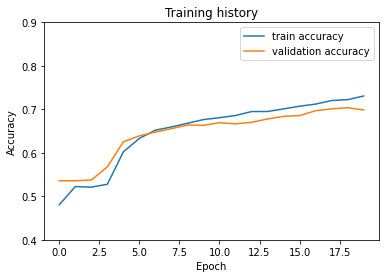

In [22]:
import matplotlib.pyplot as plt
plt.plot(history['polarity_train_acc'], label='train accuracy')
plt.plot(history['polarity_valid_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0.4, 0.9])

In [23]:
def get_classification_report(test_loader, model, model_path=None):
    if model_path is not None: # load the saved model
        print('Loading saved model from: {}'.format(model_path))
        model.load_state_dict(torch.load(model_path))
    model = to_device(model, device)   
    
    model.eval()
    final_pred_polarity_tags = []
    final_true_polarity_tags = []


    with torch.no_grad():
        for data in tqdm(test_loader, total=len(test_loader)):
            for i in range(len(data)):
                data[i] = data[i].to(device)

            l_feature, g_feature, label = data
            l_feature, g_feature, label = l_feature.long(), g_feature.long(), label.long()
            pred_logits = model(l_feature, g_feature)

            pred_tags = pred_logits.max(-1)[1]

            final_pred_polarity_tags.extend(pred_tags)
            final_true_polarity_tags.extend(label)

    final_pred_polarity_tags = torch.stack(final_pred_polarity_tags).cpu()
    final_true_polarity_tags = torch.stack(final_true_polarity_tags).cpu()
        
    print(classification_report(final_true_polarity_tags, final_pred_polarity_tags, 
                                target_names=["Neutral", "Positive", "Negative"]))
    
get_classification_report(test_loader, model, model_path=MODEL_PATH)

Loading saved model from: model_task2.bin


100%|██████████| 2/2 [00:01<00:00,  1.48it/s]

              precision    recall  f1-score   support

     Neutral       0.48      0.28      0.36       212
    Positive       0.76      0.86      0.81       622
    Negative       0.64      0.65      0.64       327

    accuracy                           0.70      1161
   macro avg       0.63      0.60      0.60      1161
weighted avg       0.68      0.70      0.68      1161



## Alpha = 0.8

In [24]:
device = get_default_device()

NUM_EPOCHS = 20
TRAIN_BATCH_SIZE = 128
VALID_BATCH_SIZE = 1024

NUM_POLARITY_TAGS = 3

history = {
    "train_loss": list(),
    "polarity_train_acc": list(),
    "valid_loss": list(),
    "polarity_valid_acc": list(),
}

best_loss = np.inf

dataset = TensorDataset(torch.Tensor(X_l_train), torch.Tensor(X_g_train), torch.Tensor(y_train))
print(f"train samples:{len(dataset)}")
train_loader = DataLoader(dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True, drop_last=True)

dataset_valid = TensorDataset(torch.Tensor(X_l_valid),  torch.Tensor(X_g_valid), torch.Tensor(y_valid))
print(f"valid samples:{len(dataset_valid)}")
test_loader = DataLoader(dataset_valid, batch_size=VALID_BATCH_SIZE)

model = to_device(Model(general_embedding,  num_classes=3, alpha = 0.8), device)

torch.cuda.empty_cache()

parameters = [p for p in model.parameters() if p.requires_grad]
optimizer = AdamW(parameters, lr=1e-4)


for epoch in range(NUM_EPOCHS):
    train_losses = []
    train_acc = []
    test_loss = []
    test_acc = []
    train_f1 = []
    test_f1 = []

    model.train()
    preds = []
    masks = []
    labels = []
    for data in tqdm(train_loader, total=len(train_loader)):
        for i in range(len(data)):
            data[i] = data[i].to(device)
        l_feature, g_feature, label = data
        l_feature, g_feature, label = l_feature.long(), g_feature.long(), label.long()

        optimizer.zero_grad()
        pred_logits = model(l_feature, g_feature)
        loss = loss_fn(pred_logits, label, 3)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

        pred_tags = pred_logits.max(-1)[1]
        preds.append(pred_tags)
        labels.append(label)

    avg_train_acc, avg_train_f1, train_cm = cal_acc(preds,labels)
    avg_train_loss = sum(train_losses) / len(train_losses)

    preds = []
    masks = []
    labels = []
    with torch.no_grad():
        for data in tqdm(test_loader, total=len(test_loader)):
            for i in range(len(data)):
                data[i] = data[i].to(device)
            l_feature, g_feature, label = data
            l_feature, g_feature, label = l_feature.long(), g_feature.long(), label.long()
            pred_logits = model(l_feature, g_feature)
            loss = loss_fn(pred_logits, label, 3)

            test_loss.append(loss.item())

            pred_tags = pred_logits.max(-1)[1]

            preds.append(pred_tags)
            labels.append(label)

    avg_test_acc, avg_test_f1, test_cm = cal_acc(preds,  labels)
    avg_test_loss = sum(test_loss) / len(test_loss)

    print(f"\nepoch {epoch}")
    print("\ttrain_loss:{:.3f} valid_loss:{:.3f}".format(avg_train_loss, avg_test_loss))
    print("\ttrain_acc:{:.2%} valid_acc:{:.2%}".format(avg_train_acc, avg_test_acc))
    print("\ttrain_f1:{:.3f} valid_f1:{:.3f}".format(avg_train_f1, avg_test_f1))
    print(f"\ttrain_confusion_matrix:\n{train_cm}")
    print(f"\tvalid_confusion_matrix:\n{test_cm}")

    if avg_test_loss < best_loss:
        torch.save(model.state_dict(), MODEL_PATH)
        best_loss = avg_test_loss    
        
    history['train_loss'].append(avg_train_loss)
    history['polarity_train_acc'].append(avg_train_acc.cpu().numpy())
    history['valid_loss'].append(avg_test_loss)
    history['polarity_valid_acc'].append(avg_test_acc.cpu().numpy())
        
    


train samples:4641
valid samples:1161


100%|██████████| 2/2 [00:01<00:00,  1.64it/s]



epoch 0
	train_loss:1.088 valid_loss:1.058
	train_acc:41.86% valid_acc:53.57%
	train_f1:0.373 valid_f1:0.376
	train_confusion_matrix:
[[ 223  619   61]
 [ 637 1641  126]
 [ 346  890   65]]
	valid_confusion_matrix:
[[  0 212   0]
 [  1 621   0]
 [  1 325   1]]


100%|██████████| 2/2 [00:01<00:00,  1.66it/s]



epoch 1
	train_loss:1.035 valid_loss:0.996
	train_acc:52.15% valid_acc:53.57%
	train_f1:0.357 valid_f1:0.374
	train_confusion_matrix:
[[   0  902    0]
 [   0 2403    0]
 [   0 1303    0]]
	valid_confusion_matrix:
[[  0 212   0]
 [  0 622   0]
 [  0 327   0]]


100%|██████████| 2/2 [00:01<00:00,  1.70it/s]



epoch 2
	train_loss:0.994 valid_loss:0.961
	train_acc:52.28% valid_acc:53.57%
	train_f1:0.359 valid_f1:0.374
	train_confusion_matrix:
[[   0  904    0]
 [   0 2409    0]
 [   0 1295    0]]
	valid_confusion_matrix:
[[  0 212   0]
 [  0 622   0]
 [  0 327   0]]


100%|██████████| 2/2 [00:01<00:00,  1.65it/s]



epoch 3
	train_loss:0.946 valid_loss:0.887
	train_acc:52.45% valid_acc:55.47%
	train_f1:0.365 valid_f1:0.424
	train_confusion_matrix:
[[   0  894    5]
 [   0 2403    4]
 [   0 1288   14]]
	valid_confusion_matrix:
[[  0 200  12]
 [  0 614   8]
 [  0 297  30]]


100%|██████████| 2/2 [00:01<00:00,  1.66it/s]



epoch 4
	train_loss:0.874 valid_loss:0.840
	train_acc:59.51% valid_acc:61.41%
	train_f1:0.512 valid_f1:0.553
	train_confusion_matrix:
[[   0  638  265]
 [   0 2232  172]
 [   0  791  510]]
	valid_confusion_matrix:
[[  0 100 112]
 [  0 519 103]
 [  0 133 194]]


100%|██████████| 2/2 [00:01<00:00,  1.66it/s]



epoch 5
	train_loss:0.835 valid_loss:0.810
	train_acc:63.48% valid_acc:64.08%
	train_f1:0.567 valid_f1:0.575
	train_confusion_matrix:
[[   0  440  463]
 [   0 2064  343]
 [   0  437  861]]
	valid_confusion_matrix:
[[  0 113  99]
 [  0 543  79]
 [  0 126 201]]


100%|██████████| 2/2 [00:01<00:00,  1.66it/s]



epoch 6
	train_loss:0.810 valid_loss:0.790
	train_acc:65.10% valid_acc:65.46%
	train_f1:0.583 valid_f1:0.592
	train_confusion_matrix:
[[   0  421  474]
 [   0 2085  324]
 [   0  389  915]]
	valid_confusion_matrix:
[[  0  92 120]
 [  0 531  91]
 [  0  98 229]]


100%|██████████| 2/2 [00:01<00:00,  1.67it/s]



epoch 7
	train_loss:0.790 valid_loss:0.781
	train_acc:66.15% valid_acc:65.55%
	train_f1:0.595 valid_f1:0.594
	train_confusion_matrix:
[[   0  367  530]
 [   0 2043  362]
 [   0  301 1005]]
	valid_confusion_matrix:
[[  0  87 125]
 [  0 526  96]
 [  0  92 235]]


100%|██████████| 2/2 [00:01<00:00,  1.70it/s]



epoch 8
	train_loss:0.774 valid_loss:0.772
	train_acc:66.82% valid_acc:65.98%
	train_f1:0.600 valid_f1:0.596
	train_confusion_matrix:
[[   1  368  535]
 [   0 2060  346]
 [   0  280 1018]]
	valid_confusion_matrix:
[[  0  93 119]
 [  0 536  86]
 [  0  97 230]]


100%|██████████| 2/2 [00:01<00:00,  1.66it/s]



epoch 9
	train_loss:0.760 valid_loss:0.759
	train_acc:67.23% valid_acc:66.67%
	train_f1:0.605 valid_f1:0.602
	train_confusion_matrix:
[[   3  370  527]
 [   2 2057  349]
 [   0  262 1038]]
	valid_confusion_matrix:
[[  0  93 119]
 [  0 539  83]
 [  0  92 235]]


100%|██████████| 2/2 [00:01<00:00,  1.66it/s]



epoch 10
	train_loss:0.745 valid_loss:0.759
	train_acc:67.82% valid_acc:66.67%
	train_f1:0.611 valid_f1:0.604
	train_confusion_matrix:
[[   8  387  505]
 [   3 2081  318]
 [   1  269 1036]]
	valid_confusion_matrix:
[[  2 101 109]
 [  0 545  77]
 [  2  98 227]]


100%|██████████| 2/2 [00:01<00:00,  1.66it/s]



epoch 11
	train_loss:0.732 valid_loss:0.751
	train_acc:68.29% valid_acc:67.27%
	train_f1:0.620 valid_f1:0.613
	train_confusion_matrix:
[[  17  380  501]
 [   9 2077  323]
 [   8  240 1053]]
	valid_confusion_matrix:
[[  6 115  91]
 [  3 549  70]
 [  2  99 226]]


100%|██████████| 2/2 [00:01<00:00,  1.71it/s]



epoch 12
	train_loss:0.721 valid_loss:0.746
	train_acc:69.01% valid_acc:67.36%
	train_f1:0.630 valid_f1:0.616
	train_confusion_matrix:
[[  34  395  473]
 [  19 2098  285]
 [  10  246 1048]]
	valid_confusion_matrix:
[[  8 119  85]
 [  4 550  68]
 [  4  99 224]]


100%|██████████| 2/2 [00:01<00:00,  1.67it/s]



epoch 13
	train_loss:0.717 valid_loss:0.743
	train_acc:69.25% valid_acc:68.22%
	train_f1:0.638 valid_f1:0.634
	train_confusion_matrix:
[[  52  406  442]
 [  22 2100  286]
 [  26  235 1039]]
	valid_confusion_matrix:
[[ 17 110  85]
 [  8 550  64]
 [  6  96 225]]


100%|██████████| 2/2 [00:01<00:00,  1.67it/s]



epoch 14
	train_loss:0.704 valid_loss:0.740
	train_acc:69.94% valid_acc:67.27%
	train_f1:0.650 valid_f1:0.624
	train_confusion_matrix:
[[  74  393  431]
 [  39 2109  260]
 [  28  234 1040]]
	valid_confusion_matrix:
[[ 17 120  75]
 [ 10 554  58]
 [  9 108 210]]


100%|██████████| 2/2 [00:01<00:00,  1.67it/s]



epoch 15
	train_loss:0.697 valid_loss:0.735
	train_acc:70.25% valid_acc:68.30%
	train_f1:0.660 valid_f1:0.648
	train_confusion_matrix:
[[ 102  376  424]
 [  56 2104  243]
 [  44  228 1031]]
	valid_confusion_matrix:
[[ 24  80 108]
 [ 20 516  86]
 [  8  66 253]]


100%|██████████| 2/2 [00:01<00:00,  1.61it/s]



epoch 16
	train_loss:0.689 valid_loss:0.728
	train_acc:70.90% valid_acc:68.99%
	train_f1:0.671 valid_f1:0.648
	train_confusion_matrix:
[[ 127  362  412]
 [  66 2096  241]
 [  50  210 1044]]
	valid_confusion_matrix:
[[ 23 113  76]
 [ 13 550  59]
 [ 13  86 228]]


100%|██████████| 2/2 [00:01<00:00,  1.69it/s]



epoch 17
	train_loss:0.681 valid_loss:0.725
	train_acc:71.03% valid_acc:69.85%
	train_f1:0.675 valid_f1:0.666
	train_confusion_matrix:
[[ 134  358  408]
 [  85 2092  225]
 [  60  199 1047]]
	valid_confusion_matrix:
[[ 34  96  82]
 [ 15 545  62]
 [ 15  80 232]]


100%|██████████| 2/2 [00:01<00:00,  1.68it/s]



epoch 18
	train_loss:0.672 valid_loss:0.717
	train_acc:71.16% valid_acc:69.85%
	train_f1:0.681 valid_f1:0.673
	train_confusion_matrix:
[[ 164  357  383]
 [  99 2094  214]
 [  75  201 1021]]
	valid_confusion_matrix:
[[ 40  80  92]
 [ 26 520  76]
 [ 12  64 251]]


100%|██████████| 2/2 [00:01<00:00,  1.66it/s]


epoch 19
	train_loss:0.668 valid_loss:0.715
	train_acc:72.01% valid_acc:70.63%
	train_f1:0.692 valid_f1:0.680
	train_confusion_matrix:
[[ 177  336  386]
 [  93 2095  219]
 [  70  186 1046]]
	valid_confusion_matrix:
[[ 43  91  78]
 [ 18 538  66]
 [ 19  69 239]]


(0.4, 0.9)

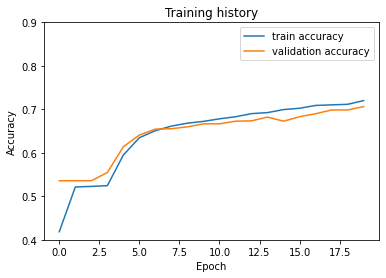

In [25]:
import matplotlib.pyplot as plt
plt.plot(history['polarity_train_acc'], label='train accuracy')
plt.plot(history['polarity_valid_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0.4, 0.9])

In [26]:
def get_classification_report(test_loader, model, model_path=None):
    if model_path is not None: # load the saved model
        print('Loading saved model from: {}'.format(model_path))
        model.load_state_dict(torch.load(model_path))
    model = to_device(model, device)   
    
    model.eval()
    final_pred_polarity_tags = []
    final_true_polarity_tags = []


    with torch.no_grad():
        for data in tqdm(test_loader, total=len(test_loader)):
            for i in range(len(data)):
                data[i] = data[i].to(device)

            l_feature, g_feature, label = data
            l_feature, g_feature, label = l_feature.long(), g_feature.long(), label.long()
            pred_logits = model(l_feature, g_feature)

            pred_tags = pred_logits.max(-1)[1]

            final_pred_polarity_tags.extend(pred_tags)
            final_true_polarity_tags.extend(label)

    final_pred_polarity_tags = torch.stack(final_pred_polarity_tags).cpu()
    final_true_polarity_tags = torch.stack(final_true_polarity_tags).cpu()
        
    print(classification_report(final_true_polarity_tags, final_pred_polarity_tags, 
                                target_names=["Neutral", "Positive", "Negative"]))
    
get_classification_report(test_loader, model, model_path=MODEL_PATH)

Loading saved model from: model_task2.bin


100%|██████████| 2/2 [00:01<00:00,  1.56it/s]

              precision    recall  f1-score   support

     Neutral       0.55      0.21      0.30       212
    Positive       0.77      0.86      0.81       622
    Negative       0.62      0.73      0.67       327

    accuracy                           0.70      1161
   macro avg       0.65      0.60      0.59      1161
weighted avg       0.69      0.70      0.68      1161



## Alpha = 1

In [27]:
device = get_default_device()

NUM_EPOCHS = 20
TRAIN_BATCH_SIZE = 128
VALID_BATCH_SIZE = 1024

NUM_POLARITY_TAGS = 3

history = {
    "train_loss": list(),
    "polarity_train_acc": list(),
    "valid_loss": list(),
    "polarity_valid_acc": list(),
}

best_loss = np.inf

dataset = TensorDataset(torch.Tensor(X_l_train), torch.Tensor(X_g_train), torch.Tensor(y_train))
print(f"train samples:{len(dataset)}")
train_loader = DataLoader(dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True, drop_last=True)

dataset_valid = TensorDataset(torch.Tensor(X_l_valid),  torch.Tensor(X_g_valid), torch.Tensor(y_valid))
print(f"valid samples:{len(dataset_valid)}")
test_loader = DataLoader(dataset_valid, batch_size=VALID_BATCH_SIZE)

model = to_device(Model(general_embedding,  num_classes=3, alpha = 1), device)

torch.cuda.empty_cache()

parameters = [p for p in model.parameters() if p.requires_grad]
optimizer = AdamW(parameters, lr=1e-4)


for epoch in range(NUM_EPOCHS):
    train_losses = []
    train_acc = []
    test_loss = []
    test_acc = []
    train_f1 = []
    test_f1 = []

    model.train()
    preds = []
    masks = []
    labels = []
    for data in tqdm(train_loader, total=len(train_loader)):
        for i in range(len(data)):
            data[i] = data[i].to(device)
        l_feature, g_feature, label = data
        l_feature, g_feature, label = l_feature.long(), g_feature.long(), label.long()

        optimizer.zero_grad()
        pred_logits = model(l_feature, g_feature)
        loss = loss_fn(pred_logits, label, 3)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

        pred_tags = pred_logits.max(-1)[1]
        preds.append(pred_tags)
        labels.append(label)

    avg_train_acc, avg_train_f1, train_cm = cal_acc(preds,labels)
    avg_train_loss = sum(train_losses) / len(train_losses)

    preds = []
    masks = []
    labels = []
    with torch.no_grad():
        for data in tqdm(test_loader, total=len(test_loader)):
            for i in range(len(data)):
                data[i] = data[i].to(device)
            l_feature, g_feature, label = data
            l_feature, g_feature, label = l_feature.long(), g_feature.long(), label.long()
            pred_logits = model(l_feature, g_feature)
            loss = loss_fn(pred_logits, label, 3)

            test_loss.append(loss.item())

            pred_tags = pred_logits.max(-1)[1]

            preds.append(pred_tags)
            labels.append(label)

    avg_test_acc, avg_test_f1, test_cm = cal_acc(preds,  labels)
    avg_test_loss = sum(test_loss) / len(test_loss)

    print(f"\nepoch {epoch}")
    print("\ttrain_loss:{:.3f} valid_loss:{:.3f}".format(avg_train_loss, avg_test_loss))
    print("\ttrain_acc:{:.2%} valid_acc:{:.2%}".format(avg_train_acc, avg_test_acc))
    print("\ttrain_f1:{:.3f} valid_f1:{:.3f}".format(avg_train_f1, avg_test_f1))
    print(f"\ttrain_confusion_matrix:\n{train_cm}")
    print(f"\tvalid_confusion_matrix:\n{test_cm}")

    if avg_test_loss < best_loss:
        torch.save(model.state_dict(), MODEL_PATH)
        best_loss = avg_test_loss    
        
    history['train_loss'].append(avg_train_loss)
    history['polarity_train_acc'].append(avg_train_acc.cpu().numpy())
    history['valid_loss'].append(avg_test_loss)
    history['polarity_valid_acc'].append(avg_test_acc.cpu().numpy())
        
    


train samples:4641
valid samples:1161


100%|██████████| 2/2 [00:01<00:00,  1.57it/s]



epoch 0
	train_loss:1.089 valid_loss:1.062
	train_acc:41.43% valid_acc:52.97%
	train_f1:0.395 valid_f1:0.380
	train_confusion_matrix:
[[  56  467  375]
 [  92 1295 1020]
 [  61  684  558]]
	valid_confusion_matrix:
[[  0 211   1]
 [  0 609  13]
 [  0 321   6]]


100%|██████████| 2/2 [00:01<00:00,  1.62it/s]



epoch 1
	train_loss:1.038 valid_loss:0.998
	train_acc:52.26% valid_acc:53.66%
	train_f1:0.361 valid_f1:0.376
	train_confusion_matrix:
[[   0  901    2]
 [   0 2402    3]
 [   0 1294    6]]
	valid_confusion_matrix:
[[  0 212   0]
 [  0 622   0]
 [  0 326   1]]


100%|██████████| 2/2 [00:01<00:00,  1.64it/s]



epoch 2
	train_loss:0.991 valid_loss:0.957
	train_acc:52.17% valid_acc:53.83%
	train_f1:0.359 valid_f1:0.381
	train_confusion_matrix:
[[   0  906    0]
 [   0 2400    2]
 [   0 1296    4]]
	valid_confusion_matrix:
[[  0 212   0]
 [  0 621   1]
 [  0 323   4]]


100%|██████████| 2/2 [00:01<00:00,  1.61it/s]



epoch 3
	train_loss:0.934 valid_loss:0.879
	train_acc:53.06% valid_acc:56.33%
	train_f1:0.379 valid_f1:0.452
	train_confusion_matrix:
[[   0  877   22]
 [   0 2404    5]
 [   0 1259   41]]
	valid_confusion_matrix:
[[  0 187  25]
 [  0 601  21]
 [  0 274  53]]


100%|██████████| 2/2 [00:01<00:00,  1.64it/s]



epoch 4
	train_loss:0.872 valid_loss:0.837
	train_acc:59.61% valid_acc:62.79%
	train_f1:0.512 valid_f1:0.561
	train_confusion_matrix:
[[   0  631  267]
 [   0 2250  158]
 [   0  805  497]]
	valid_confusion_matrix:
[[  0 117  95]
 [  0 547  75]
 [  0 145 182]]


100%|██████████| 2/2 [00:01<00:00,  1.63it/s]



epoch 5
	train_loss:0.836 valid_loss:0.809
	train_acc:63.30% valid_acc:64.77%
	train_f1:0.564 valid_f1:0.581
	train_confusion_matrix:
[[   0  442  458]
 [   0 2098  302]
 [   0  489  819]]
	valid_confusion_matrix:
[[  0 111 101]
 [  0 549  73]
 [  0 124 203]]


100%|██████████| 2/2 [00:01<00:00,  1.53it/s]



epoch 6
	train_loss:0.809 valid_loss:0.795
	train_acc:64.97% valid_acc:64.60%
	train_f1:0.583 valid_f1:0.587
	train_confusion_matrix:
[[   0  379  516]
 [   0 2062  348]
 [   0  371  932]]
	valid_confusion_matrix:
[[  0  75 137]
 [  0 516 106]
 [  0  93 234]]


100%|██████████| 2/2 [00:01<00:00,  1.67it/s]



epoch 7
	train_loss:0.792 valid_loss:0.776
	train_acc:65.60% valid_acc:65.03%
	train_f1:0.591 valid_f1:0.591
	train_confusion_matrix:
[[   0  335  568]
 [   0 1998  405]
 [   0  277 1025]]
	valid_confusion_matrix:
[[  0  82 130]
 [  0 511 111]
 [  0  83 244]]


100%|██████████| 2/2 [00:01<00:00,  1.69it/s]



epoch 8
	train_loss:0.777 valid_loss:0.767
	train_acc:66.56% valid_acc:65.81%
	train_f1:0.599 valid_f1:0.594
	train_confusion_matrix:
[[   0  342  560]
 [   0 2039  363]
 [   0  276 1028]]
	valid_confusion_matrix:
[[  0  97 115]
 [  0 534  88]
 [  0  97 230]]


100%|██████████| 2/2 [00:01<00:00,  1.63it/s]



epoch 9
	train_loss:0.769 valid_loss:0.765
	train_acc:66.73% valid_acc:66.24%
	train_f1:0.601 valid_f1:0.604
	train_confusion_matrix:
[[   3  361  540]
 [   3 2038  362]
 [   2  265 1034]]
	valid_confusion_matrix:
[[  2  81 129]
 [  1 516 105]
 [  0  76 251]]


100%|██████████| 2/2 [00:01<00:00,  1.69it/s]



epoch 10
	train_loss:0.753 valid_loss:0.751
	train_acc:67.69% valid_acc:67.01%
	train_f1:0.611 valid_f1:0.608
	train_confusion_matrix:
[[  10  383  506]
 [   5 2083  319]
 [   2  274 1026]]
	valid_confusion_matrix:
[[  3 107 102]
 [  1 542  79]
 [  1  93 233]]


100%|██████████| 2/2 [00:01<00:00,  1.68it/s]



epoch 11
	train_loss:0.738 valid_loss:0.750
	train_acc:68.19% valid_acc:67.27%
	train_f1:0.617 valid_f1:0.612
	train_confusion_matrix:
[[  14  382  496]
 [   4 2095  310]
 [   4  270 1033]]
	valid_confusion_matrix:
[[  4 106 102]
 [  1 538  83]
 [  2  86 239]]


100%|██████████| 2/2 [00:01<00:00,  1.62it/s]



epoch 12
	train_loss:0.730 valid_loss:0.745
	train_acc:68.71% valid_acc:67.96%
	train_f1:0.625 valid_f1:0.624
	train_confusion_matrix:
[[  27  402  474]
 [  13 2097  294]
 [  11  248 1042]]
	valid_confusion_matrix:
[[ 10 113  89]
 [  3 547  72]
 [  2  93 232]]


100%|██████████| 2/2 [00:01<00:00,  1.62it/s]



epoch 13
	train_loss:0.722 valid_loss:0.740
	train_acc:69.23% valid_acc:67.96%
	train_f1:0.634 valid_f1:0.632
	train_confusion_matrix:
[[  39  397  463]
 [  22 2105  280]
 [  18  238 1046]]
	valid_confusion_matrix:
[[ 14  97 101]
 [  7 531  84]
 [  6  77 244]]


100%|██████████| 2/2 [00:01<00:00,  1.65it/s]



epoch 14
	train_loss:0.713 valid_loss:0.742
	train_acc:69.77% valid_acc:68.99%
	train_f1:0.644 valid_f1:0.647
	train_confusion_matrix:
[[  56  390  454]
 [  38 2104  264]
 [  19  228 1055]]
	valid_confusion_matrix:
[[ 19  89 104]
 [ 13 525  84]
 [  3  67 257]]


100%|██████████| 2/2 [00:01<00:00,  1.66it/s]



epoch 15
	train_loss:0.708 valid_loss:0.733
	train_acc:70.05% valid_acc:69.51%
	train_f1:0.654 valid_f1:0.656
	train_confusion_matrix:
[[  85  388  426]
 [  46 2104  259]
 [  38  223 1039]]
	valid_confusion_matrix:
[[ 24  96  92]
 [ 14 532  76]
 [ 10  66 251]]


100%|██████████| 2/2 [00:01<00:00,  1.66it/s]



epoch 16
	train_loss:0.697 valid_loss:0.726
	train_acc:70.96% valid_acc:68.99%
	train_f1:0.669 valid_f1:0.649
	train_confusion_matrix:
[[ 116  372  411]
 [  63 2110  229]
 [  45  218 1044]]
	valid_confusion_matrix:
[[ 23 104  85]
 [ 10 540  72]
 [ 12  77 238]]


100%|██████████| 2/2 [00:01<00:00,  1.62it/s]



epoch 17
	train_loss:0.691 valid_loss:0.761
	train_acc:71.01% valid_acc:68.13%
	train_f1:0.675 valid_f1:0.642
	train_confusion_matrix:
[[ 135  347  419]
 [  72 2100  229]
 [  62  207 1037]]
	valid_confusion_matrix:
[[ 27 111  74]
 [ 12 554  56]
 [ 19  98 210]]


100%|██████████| 2/2 [00:01<00:00,  1.63it/s]



epoch 18
	train_loss:0.686 valid_loss:0.722
	train_acc:71.33% valid_acc:70.28%
	train_f1:0.680 valid_f1:0.673
	train_confusion_matrix:
[[ 151  367  381]
 [  72 2126  208]
 [  80  213 1010]]
	valid_confusion_matrix:
[[ 36  86  90]
 [ 12 534  76]
 [ 15  66 246]]


100%|██████████| 2/2 [00:01<00:00,  1.63it/s]


epoch 19
	train_loss:0.680 valid_loss:0.719
	train_acc:71.51% valid_acc:70.28%
	train_f1:0.685 valid_f1:0.681
	train_confusion_matrix:
[[ 163  327  413]
 [  98 2089  214]
 [  71  190 1043]]
	valid_confusion_matrix:
[[ 48  88  76]
 [ 18 536  68]
 [ 28  67 232]]


(0.4, 0.9)

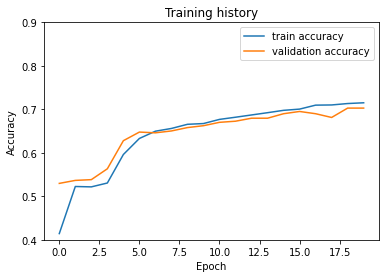

In [28]:
import matplotlib.pyplot as plt
plt.plot(history['polarity_train_acc'], label='train accuracy')
plt.plot(history['polarity_valid_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0.4, 0.9])

In [29]:
def get_classification_report(test_loader, model, model_path=None):
    if model_path is not None: # load the saved model
        print('Loading saved model from: {}'.format(model_path))
        model.load_state_dict(torch.load(model_path))
    model = to_device(model, device)   
    
    model.eval()
    final_pred_polarity_tags = []
    final_true_polarity_tags = []


    with torch.no_grad():
        for data in tqdm(test_loader, total=len(test_loader)):
            for i in range(len(data)):
                data[i] = data[i].to(device)

            l_feature, g_feature, label = data
            l_feature, g_feature, label = l_feature.long(), g_feature.long(), label.long()
            pred_logits = model(l_feature, g_feature)

            pred_tags = pred_logits.max(-1)[1]

            final_pred_polarity_tags.extend(pred_tags)
            final_true_polarity_tags.extend(label)

    final_pred_polarity_tags = torch.stack(final_pred_polarity_tags).cpu()
    final_true_polarity_tags = torch.stack(final_true_polarity_tags).cpu()
        
    print(classification_report(final_true_polarity_tags, final_pred_polarity_tags, 
                                target_names=["Neutral", "Positive", "Negative"]))
    
get_classification_report(test_loader, model, model_path=MODEL_PATH)

Loading saved model from: model_task2.bin


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]

              precision    recall  f1-score   support

     Neutral       0.51      0.20      0.29       212
    Positive       0.77      0.86      0.81       622
    Negative       0.62      0.73      0.67       327

    accuracy                           0.70      1161
   macro avg       0.63      0.60      0.59      1161
weighted avg       0.68      0.70      0.68      1161

